# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name='./environment/Tennis_Linux/Tennis.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [5]:
for i in range(1, 6):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

Score (max over agents) from episode 1: 0.0
Score (max over agents) from episode 2: 0.0
Score (max over agents) from episode 3: 0.0
Score (max over agents) from episode 4: 0.10000000149011612
Score (max over agents) from episode 5: 0.0


### 4. Train a PPO Agent
In the following, we will train a PPO agent until the environment is solved.

In [6]:
from agents.maddpg import MADDPG

import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
def train_agent(agent, n_episodes=3500, max_t=1000, 
                weights_actor_fname='./weights/actor_model.pt',
                weights_critic_fname='./weights/critic_model.pt'):
    """Agent Training.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        weights_fname (str): path to where the final model file shall be stored
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        current_scores = np.zeros(num_agents)
        for t in range(max_t):
            # execute action and get next_state, reward, done from env
            actions = agent.act(states)            
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done
            # end episode in the last time step
            if t == max_t-1:
                dones = [True] * len(states)
            # perform agent training step
            agent.step(states, actions, rewards, next_states, dones)
            states = next_states
            current_scores += rewards
            if np.any(dones):
                break
        # save most recent score
        score = np.max(current_scores)
        scores_window.append(score)
        scores.append(score)
        print('\rEpisode {}\tAverage Score: {:.3f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.3f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=0.5:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.3f}\n'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.agent.actor.state_dict(), weights_actor_fname)
            torch.save(agent.agent.critic.state_dict(), weights_critic_fname)
            break
    return scores

In [8]:
agent = MADDPG(state_size, action_size, [128, 128], seed=7, lr_actor=1e-3, lr_critic=1e-3, 
              update_interval=20, num_update_steps=10, noise_std=1.0, noise_reduction=0.999,
              noise_std_min=0.05, batch_size=256, buffer_size=int(5e5), warmup=1e4, tau=1e-3)
scores = train_agent(agent)

Episode 100	Average Score: 0.016
Episode 200	Average Score: 0.019
Episode 300	Average Score: 0.015
Episode 400	Average Score: 0.023
Episode 500	Average Score: 0.009
Episode 600	Average Score: 0.018
Episode 700	Average Score: 0.059
Episode 800	Average Score: 0.108
Episode 900	Average Score: 0.167
Episode 921	Average Score: 0.501
Environment solved in 821 episodes!	Average Score: 0.501



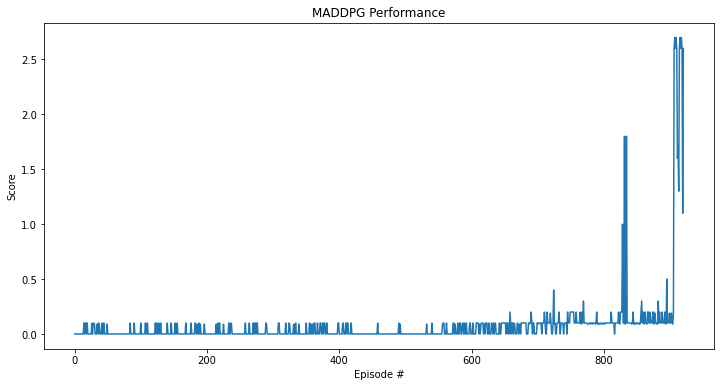

In [9]:
# plot the scores
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.title('MADDPG Performance')
plt.show()

In [10]:
# Show agent's learned tennis skills
# create agent, load network weights
agent = MADDPG(state_size, action_size, [128, 128], seed=5, lr_actor=8e-4, lr_critic=8e-4, 
              update_interval=20, num_update_steps=10, noise_std=1.0, noise_reduction=0.999,
              noise_std_min=0.05, batch_size=256, buffer_size=0, warmup=0, tau=1e-3)
agent.agent.actor.load_state_dict(torch.load('./weights/actor_model.pt'))
agent.agent.critic.load_state_dict(torch.load('./weights/critic_model.pt'))

# let agent play tennis
env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = agent.act(states, add_noise=False)       # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Score: {}'.format(np.max(scores)))

Score: 2.600000038743019


In [11]:
env.close()